In [341]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import time

from pyspark.sql import SparkSession
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS

import ast
import os
import pickle
import json


from pprint import pprint

import sys 
sys.path.insert(1, "../")
from workloads.util import use_results, use_dataset, read_config, log_dataset, join_queries_features
from workloads.recsys.recsys_util import get_features, get_feature_update, predict_rating

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1057]:
dataset_dir = use_dataset("ml-latest-small")
results_dir = use_results("ml-latest-small")
#experiment = "results_workers_user_32_fifo_learningrate_0.02_userfeaturereg_0.01_sleep_0.001"

experiment = "results_user_workers_1_random_learningrate_0.02_userfeaturereg_0.01_sleep_0.001"

/data/wooders/ralf-vldb//datasets/ml-latest-small


## Read Experiment Results

In [1058]:
events_df = pd.read_csv(f'{dataset_dir}/test.csv')

In [1059]:
results_df = pd.read_csv(f'{results_dir}/{experiment}.csv')
timestamp_df = pd.read_csv(f'{results_dir}/timestamps/{experiment}.csv').set_index("timestamp_ms")

In [1060]:
results_df

,user_id,user_features,ingest_time,timestamp,processing_time,runtime
0,45,"[0.08245328466150217, 0.008904671218049132, 0....",1.646088e+09,81,1.646088e+09,1.127252
1,199,"[0.1694399605046079, 0.06444689323045857, 0.07...",1.646088e+09,99,1.646088e+09,0.328351
2,438,"[-0.004985034734766194, 0.16579137949253683, 0...",1.646088e+09,225,1.646088e+09,0.322950
3,599,"[0.14095855890731415, 0.054864847826012, -0.01...",1.646088e+09,697,1.646088e+09,0.318354
4,109,"[0.043597819015079475, 0.05078434367527026, 0....",1.646088e+09,458,1.646088e+09,0.310438
...,...,...,...,...,...,...
268,484,"[0.0070248142828930275, 0.04898516396637008, 0...",1.646088e+09,7550,1.646088e+09,0.312712
269,11,"[0.07368706662557355, 0.04044513785890738, 0.2...",1.646088e+09,33105,1.646088e+09,0.312297
270,123,"[0.12139669712697888, 0.06590976631822042, 0.1...",1.646088e+09,15670,1.646088e+09,0.311566
271,199,"[0.1838103146525551, 0.06129471548687382, 0.09...",1.646088e+09,33269,1.646088e+09,0.314605


In [1061]:
timestamp_df

,timestamp
timestamp_ms,
81,1.646088e+09
82,1.646088e+09
83,1.646088e+09
84,1.646088e+09
85,1.646088e+09
...,...
39995,1.646088e+09
39996,1.646088e+09
39997,1.646088e+09


## Read oracles 
(Trained with data up until last timestep for 10 iterations)

In [1024]:
oracle_user_matrix = pickle.load(open(f"{results_dir}/oracle_models/user_matrix_5665418.pkl", "rb")).cpu().detach().numpy()
oracle_movie_matrix = pickle.load(open(f"{results_dir}/oracle_models/movie_matrix_5665418.pkl", "rb")).cpu().detach().numpy()

## Read Dataset 

In [1025]:
movie_to_index = json.load(open(f"{dataset_dir}/movie_to_index.json", "r"))
user_to_index = json.load(open(f"{dataset_dir}/user_to_index.json", "r"))
user_matrix = pickle.load(open(f"{dataset_dir}/user_matrix.pkl", "rb"))
movie_matrix = pickle.load(open(f"{dataset_dir}/movie_matrix.pkl", "rb"))
A = pickle.load(open(f"{dataset_dir}/A.pkl", "rb"))
R = pickle.load(open(f"{dataset_dir}/R.pkl", "rb"))

## Evaluate Experiment Features 

In [1026]:
def updated_embedding(df, ui): 
    
    # calculate embedding from dataframe of updates form a single user

    ui = user_to_index[str(ui)]
    streaming_user_matrix = np.array(user_matrix, copy=True) 
    A_matrix = np.array(A, copy=True)
    R_matrix = np.array(R, copy=True)
    user_feature_reg = 10

    for index, row in df.iterrows():
        ui = user_to_index[str(int(row["user_id"]))]
        mi = movie_to_index[str(int(row["movie_id"]))]
        A_matrix[ui][mi] = row["rating"]
        R_matrix[ui][mi] = 1
        
    Ri = R_matrix[ui]
    n_factors = len(user_matrix[ui])

    return np.linalg.solve(
        np.dot(movie_matrix.T, np.dot(np.diag(Ri), movie_matrix)) + user_feature_reg * np.eye(n_factors),
        np.dot(movie_matrix.T, np.dot(np.diag(Ri), A_matrix[ui].T))
    ).T

In [1027]:
# map real timestamps 

ts_to_time = {}

for index, row in results_df.iterrows(): 
    if row["timestamp"] not in ts_to_time: 
        ts_to_time[row["timestamp"]] = row["ingest_time"]

In [1028]:
cache = {}

In [1075]:
def evaluate_user(user, ts):
    
#     # oracle feature 
#     user_df = events_df[(events_df["user_id"] == user) & (events_df["timestamp"] < ts)]
    
#     if f"{user}_{ts}" in cache: 
#         oracle_feature = cache[f"{user}_{ts}"]
#     else:
#         oracle_feature = updated_embedding(user_df, user).tolist()
#         cache[f"{user}_{ts}"] = oracle_feature

    
    ui = user_to_index[str(user)]
    oracle_feature = oracle_user_matrix[ui]
    
    processing_time = timestamp_df.loc[ts].timestamp
    #print(processing_time)
    # actual feature 
    update_df = results_df[(results_df["user_id"] == user) & (results_df["processing_time"] <= processing_time)]
    update_ts = update_df.timestamp.max() 
    
    processed_df = events_df[(events_df["user_id"] == user) & (events_df["timestamp"] <= update_ts)]
    total_df = events_df[(events_df["user_id"] == user) & (events_df["timestamp"] <= ts)]
    

    if len(update_df.index) == 0:
        #print("no updates", user, ts)
        #print("no updates", user)
        return None
    
    #print("feature ts", update_ts, "limit", total_df.timestamp.max(), "query", ts)
    #print(update_ts, processed_df.timestamp.max())
    #print(ts_to_time[update_ts] - ts_to_time[feature_ts])
    
    feature = ast.literal_eval(update_df.user_features.tolist()[-1])
    
    # metrics 
    staleness = timestamp_df.loc[total_df.timestamp.max()].timestamp - timestamp_df.loc[update_ts].timestamp
    past_updates = len(processed_df.index)
    pending_updates = len(total_df.index) - past_updates
    
    
    # loss between features 
    feature_loss = mean_squared_error(oracle_feature, feature)
    
    # loss between predictions with features (better metric)
    oracle_pred = [np.dot(np.array(oracle_feature), movie_matrix[mid]) for mid in range(movie_matrix.shape[0])]
    pred = [np.dot(np.array(feature), movie_matrix[mid]) for mid in range(movie_matrix.shape[0])]
    print(len(pred), pred[0])
    prediction_loss = mean_squared_error(oracle_pred, pred)
    
    return {"ts": ts, "user": user, "feature_loss": feature_loss, "prediction_loss": prediction_loss, "staleness": staleness, "past_updates": past_updates, "pending_updates": pending_updates}

In [1076]:
from tqdm import tqdm 

In [1077]:
data = []

In [1078]:
#for ts in tqdm(list(ts_to_time.keys())[:50]): #[3239, 3237, 4519, 10045, 10662]: # randomly selected timestamps to evaluate at 
for ts in tqdm([100, 200, 300, 400, 500, 1000, 1500, 2000, 10000, 20000]):
    for user in events_df.user_id.value_counts().index.tolist(): #set(results_df.user_id.tolist()):
    #for user in [217]:  
        d = evaluate_user(user, ts)
        if d is not None: data.append(d)

 40%|████      | 4/10 [00:02<00:03,  1.78it/s]

5880 4.118331485196947


 50%|█████     | 5/10 [00:02<00:02,  1.69it/s]

5880 3.251196086818482
5880 4.247996406865601
5880 4.118331485196947
5880 3.345316828276098


 60%|██████    | 6/10 [00:03<00:02,  1.42it/s]

5880 3.5676360330683257
5880 3.251196086818482
5880 4.247996406865601
5880 4.118331485196947
5880 3.345316828276098
5880 3.641977026832456
5880 4.523009106222825
5880 4.195981052501931
5880 3.079324685823063
5880 3.5676360330683257


 70%|███████   | 7/10 [00:05<00:02,  1.10it/s]

5880 3.6751507136876773
5880 3.251196086818482
5880 4.247996406865601
5880 4.118331485196947
5880 3.844251295023173
5880 3.345316828276098
5880 3.641977026832456
5880 4.523009106222825
5880 4.195981052501931
5880 3.079324685823063
5880 4.126457880138782
5880 3.5676360330683257
5880 3.9198373946190634


 80%|████████  | 8/10 [00:06<00:02,  1.14s/it]

5880 3.965557672029636
5880 3.6751507136876773
5880 3.332380274395363
5880 4.280359318679932
5880 3.443106761309907
5880 3.085429396232091
5880 3.6452862981897036
5880 2.6181269635469744
5880 4.092287588611592
5880 3.50036279424081
5880 4.247996406865601
5880 4.04473986457293
5880 4.118331485196947
5880 3.8648149345389418
5880 3.844251295023173
5880 3.345316828276098
5880 3.8867575625161095
5880 4.260504319754768
5880 4.084695266540103
5880 3.9164707447404976
5880 4.456801432629402
5880 3.641977026832456
5880 4.021033278546128
5880 3.3045866281472036
5880 3.1134114453411548
5880 4.065273985723613
5880 3.7199225755594734
5880 4.650505321262963
5880 3.319965895735515
5880 3.619398312211965
5880 2.8430058505471267
5880 4.104381576155615
5880 3.7717175355886234
5880 4.34343249471967
5880 3.4690915652688434
5880 3.9828960609599733
5880 3.8811222276283046
5880 3.2179608588669764
5880 4.409789921327247
5880 3.9473841282311883
5880 4.18129637943081
5880 4.195981052501931
5880 3.079324685823063

 90%|█████████ | 9/10 [00:13<00:02,  2.74s/it]

5880 3.6751507136876773
5880 3.3328781696358494
5880 4.280359318679932
5880 3.443106761309907
5880 4.017023289530522
5880 3.085429396232091
5880 3.6823973643474943
5880 2.6181269635469744
5880 3.175632779647457
5880 4.092287588611592
5880 4.032676361813321
5880 2.901721942712191
5880 4.140764861818471
5880 3.50036279424081
5880 4.247996406865601
5880 4.04473986457293
5880 3.3464147575139975
5880 4.118331485196947


 90%|█████████ | 9/10 [00:14<00:01,  1.60s/it]


KeyboardInterrupt: 

In [1066]:
baseline_df = pd.DataFrame(data)

In [1067]:
baseline_df.staleness.mean()

4.92324660718441

In [1068]:
baseline_df.pending_updates.mean()

11.095833333333333

In [1069]:
baseline_df.prediction_loss.mean()

0.11250055896036111

In [1070]:
baseline_df.prediction_loss.mean() # workers=4

0.11250055896036111

In [1015]:
baseline_df

,ts,user,feature_loss,prediction_loss,staleness,past_updates,pending_updates
0,500,217,0.286311,0.139448,0.109591,7,208
1,500,509,0.177471,0.052308,0.972127,7,34
2,1000,202,0.217847,0.070537,0.000000,183,0
3,1000,217,0.286311,0.139448,0.109591,7,208
4,1000,408,0.139410,0.144319,2.201694,30,4
...,...,...,...,...,...,...,...
406,20000,37,0.017630,0.083504,0.000000,2,0
407,20000,1,0.081869,0.044341,0.000000,1,0
408,20000,185,0.060081,0.094968,0.000000,1,0
409,20000,100,0.046691,0.038896,0.000000,1,0


In [950]:
events_df[events_df["user_id"] == 217]

,Unnamed: 0,user_id,movie_id,rating,timestamp
2,31275,217,2231,4.0,81
7,31282,217,2278,2.0,81
31,31490,217,3529,3.0,81
37,31186,217,1711,4.0,81
47,31156,217,1589,3.0,81
...,...,...,...,...,...
14751,31436,217,3197,3.0,2603
14756,31124,217,1385,3.0,2604
14760,30967,217,459,2.0,2604
14761,30934,217,315,2.0,2604


In [1053]:
data_df = pd.DataFrame(data)

In [1054]:
data_df.pending_updates.mean()

18.93884892086331

In [1055]:
data_df.prediction_loss.mean()

0.10216298163142945

In [1056]:
data_df

,ts,user,feature_loss,prediction_loss,staleness,past_updates,pending_updates
0,500,42,0.326604,0.145695,1.189027,9,175
1,1000,600,0.500213,0.090885,0.000000,282,0
2,1000,217,0.252225,0.108099,0.000000,215,0
3,1000,42,0.326604,0.145695,1.189027,9,175
4,1000,509,0.171546,0.040402,1.452434,41,5
...,...,...,...,...,...,...,...
273,20000,503,0.095241,0.137371,0.000000,2,0
274,20000,253,0.027936,0.054908,0.000000,2,0
275,20000,319,0.026037,0.072460,0.000000,2,0
276,20000,185,0.060081,0.094968,0.000000,1,0


In [1040]:
data_df[data_df["ts"] == 1000].pending_updates.value_counts()

0      3
175    1
2      1
4      1
39     1
10     1
95     1
Name: pending_updates, dtype: int64

In [1041]:
baseline_df[baseline_df["ts"] == 1000].pending_updates.value_counts()

0      8
208    1
4      1
39     1
8      1
Name: pending_updates, dtype: int64

In [570]:
model = pickle.load(open("/data/wooders/ralf-vldb//datasets/ml-latest-small/random_forest_model", "rb"))

In [576]:
data_df["estimated_loss"] = model.predict(data_df[["staleness", "past_updates", "pending_updates"]].to_numpy())
mean_squared_error(data_df["estimated_loss"].to_numpy(), data_df["prediction_loss"].to_numpy())

0.012728850317758068

In [577]:
baseline_df["estimated_loss"] = model.predict(baseline_df[["staleness", "past_updates", "pending_updates"]].to_numpy())
mean_squared_error(baseline_df["estimated_loss"].to_numpy(), baseline_df["prediction_loss"].to_numpy())

0.014550071222087466

# Attempt to Model Loss

<AxesSubplot:xlabel='ts'>

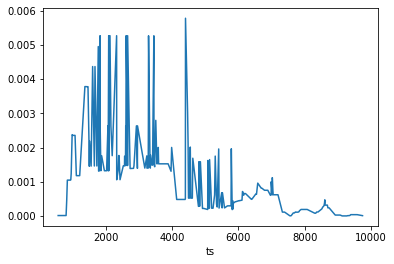

In [311]:
data_df.groupby("ts").feature_loss.mean().plot()

<AxesSubplot:xlabel='ts'>

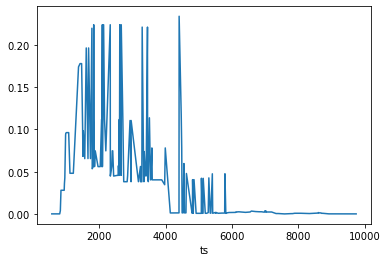

In [312]:
data_df.groupby("ts").prediction_loss.mean().plot()

<AxesSubplot:>

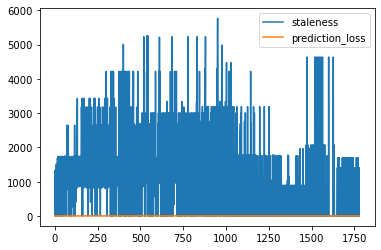

In [313]:
data_df[["staleness", "prediction_loss"]].plot()

<AxesSubplot:>

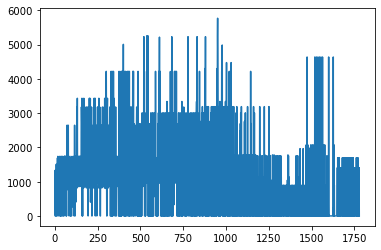

In [314]:
data_df.staleness.plot()

In [ ]:
from sklearn.model_selection import train_test_split

In [315]:
from sklearn.metrics import mean_squared_error

In [316]:
mean_squared_error(oracle_feature, feature)

0.0007864545900573374

In [325]:
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

In [330]:
x = data_df[["staleness", "past_updates", "pending_updates"]].to_numpy()
y = data_df["prediction_loss"].to_numpy()

In [326]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

In [327]:
regr = RandomForestRegressor(random_state=0)
regr.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

In [328]:
train_err = mean_squared_error(regr.predict(X_train), y_train)
print(train_err)
test_err = mean_squared_error(regr.predict(X_test), y_test)
print(test_err)

1.1604296106327372e-05
8.089973981076744e-05


In [335]:
pickle.dump(regr, open(f"{dataset_dir}/random_forest_model", "wb"))

In [331]:
clf = SGDRegressor().fit(X_train, y_train)

In [332]:
train_err = mean_squared_error(clf.predict(X_train), y_train)
print(train_err)
test_err = mean_squared_error(clf.predict(X_test), y_test)
print(test_err)

1.0662132552659519e+29
1.0047951994562867e+29


In [284]:
clf.predict()

TypeError: predict() missing 1 required positional argument: 'X'

In [285]:
x = data_df[["staleness", "past_updates"]].to_numpy()
y = data_df["prediction_loss"].to_numpy()

clf = SGDRegressor().fit(x, y)
train_err = mean_squared_error(clf.predict(x), y)
train_err

4.7943274590540256e+26

In [225]:
x = data_df[["staleness"]].to_numpy()
y = data_df["prediction_loss"].to_numpy()

#clf = SGDRegressor(loss="huber").fit(x, y)
clf = SGDRegressor(loss="huber").fit(x, y)
train_err = mean_squared_error(clf.predict(x), y)
train_err

0.003199790139035662

In [333]:
train_err = mean_squared_error([y.mean()]*y.shape[0], y)
train_err

0.0025845530474632207

In [78]:
oracle_pred = [np.dot(np.array(oracle_feature), movie_matrix[mid]) for mid in range(movie_matrix.shape[0])]
pred = [np.dot(np.array(feature), movie_matrix[mid]) for mid in range(movie_matrix.shape[0])]

In [79]:
mean_squared_error(oracle_pred, pred)

0.026040872747266245

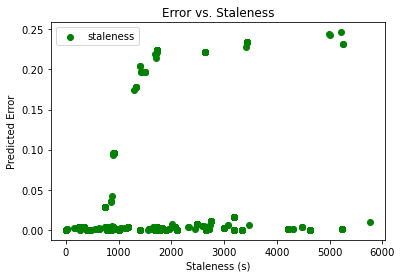

In [383]:
import matplotlib.pyplot as plt

plt.scatter(data_df["staleness"].tolist(), data_df["prediction_loss"].tolist(), c ="green", label=f"staleness")

plt.legend()
# To show the plot
plt.title("Error vs. Staleness")
plt.ylabel("Predicted Error")
plt.xlabel("Staleness (s)")
plt.show()

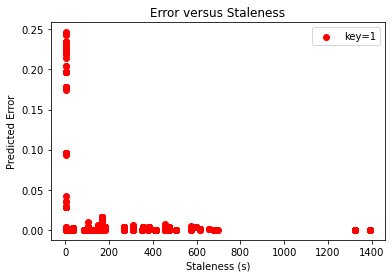

In [339]:
plt.scatter(data_df["past_updates"].tolist(), data_df["prediction_loss"].tolist(), c ="red", label=f"key={key}")

plt.legend()
# To show the plot
plt.title("Error versus Staleness")
plt.ylabel("Predicted Error")
plt.xlabel("Staleness (s)")
plt.show()

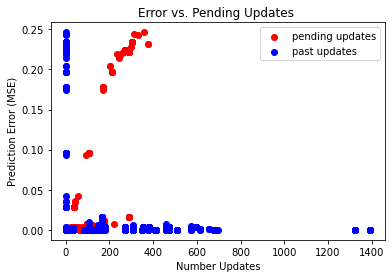

In [379]:
plt.scatter(data_df["pending_updates"].tolist(), data_df["prediction_loss"].tolist(), c ="red", label="pending updates")
plt.scatter(data_df["past_updates"].tolist(), data_df["prediction_loss"].tolist(), c ="blue", label=f"past updates")


plt.legend()
# To show the plot
plt.title("Error vs. Pending Updates ")
plt.ylabel("Prediction Error (MSE)")
plt.xlabel("Number Updates")
plt.show()

In [381]:
#data_df.to_csv("initial_als_results.csv")